![spaceship-titanic](spaceship-titanic/header.png)

In this competition the task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

# Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import random
random.seed(0)

In [2]:
DATAPATH : str = os.path.join("spaceship-titanic", "train.csv")

# Data checking

In [3]:
data = pd.read_csv(DATAPATH)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data splitting

To avoid having a look at the testing data, we will split the data before continuing the rest of the data exploration process.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(df: pd.DataFrame, target: str, test_size: float) -> tuple[pd.DataFrame]:
    features = df.loc[:, df.columns != target]
    labels = df.loc[:, target]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

    for split_indices_1, split_indices_2 in sss.split(features, labels):
        split_1 = df.loc[split_indices_1, :]
        split_2 = df.loc[split_indices_2, :]

    split_1.reset_index(inplace = True, drop = True)
    split_2.reset_index(inplace = True, drop = True)
    return split_1, split_2

In [7]:
train_df, test_df = stratified_split(df = data, target = "Transported", test_size = 0.30)
print(f"TRAIN SIZE      : {len(train_df)}")
print(f"TESTT SIZE      : {len(test_df)}")

TRAIN SIZE      : 6085
TESTT SIZE      : 2608


# Data exploration and preparation

In [8]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1230_01,Earth,False,G/189/S,TRAPPIST-1e,38.0,False,354.0,34.0,0.0,291.0,229.0,Catha Gainebergan,False
1,4021_01,Mars,False,F/832/P,TRAPPIST-1e,32.0,False,1843.0,0.0,662.0,0.0,0.0,Flys Buth,False
2,1375_02,Earth,False,F/267/S,TRAPPIST-1e,19.0,False,0.0,3.0,946.0,0.0,0.0,Gwendy Sykess,False
3,5763_02,Earth,False,F/1099/S,TRAPPIST-1e,24.0,False,NaN,0.0,0.0,838.0,193.0,Erick Alentonway,False
4,7545_01,Earth,True,G/1225/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jasony Nguerrettye,False


Cabin = Deck/Num/Side.

* I will divide cabin into two columns : Deck & Side.
* I will not keep the Num since it does not bring any information.

In [9]:
def split_cabin(df):
    # Split cabin
    cabin = {"Deck": [], "Side": []}
    for i in range(len(df)):
        cab = df.loc[i, "Cabin"]
        if not isinstance(cab, str):
            deck, side = cab, cab # cab = nan
        else:
            deck, _, side = cab.split('/')

        cabin["Deck"].append(deck)
        cabin["Side"].append(side)

    cabin = pd.DataFrame(data = cabin)
    df = pd.concat([cabin, df], axis = 1)
    df = df.drop("Cabin", axis = 1)
    return df

train_df = split_cabin(train_df)
train_df.head(10)

,Deck,Side,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,G,S,1230_01,Earth,False,TRAPPIST-1e,38.0,False,354.0,34.0,0.0,291.0,229.0,Catha Gainebergan,False
1,F,P,4021_01,Mars,False,TRAPPIST-1e,32.0,False,1843.0,0.0,662.0,0.0,0.0,Flys Buth,False
2,F,S,1375_02,Earth,False,TRAPPIST-1e,19.0,False,0.0,3.0,946.0,0.0,0.0,Gwendy Sykess,False
3,F,S,5763_02,Earth,False,TRAPPIST-1e,24.0,False,NaN,0.0,0.0,838.0,193.0,Erick Alentonway,False
4,G,S,7545_01,Earth,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jasony Nguerrettye,False
5,B,P,7117_01,Europa,True,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,Alasmon Secont,True
6,G,P,8129_02,Earth,False,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Frey Casonston,True
7,B,P,3747_04,Europa,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Tabiton Ambleetive,True
8,NaN,NaN,3034_01,Europa,False,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,Dscheat Noxnuther,False
9,A,P,2835_01,Europa,False,55 Cancri e,26.0,True,0.0,186.0,NaN,548.0,5058.0,Sadirk Unaring,False


PassengerId, Name are useless features for prediction.

In [10]:
train_df = train_df.drop(["PassengerId", "Name"], axis = 1)

Specify numerical & categorical data.

In [11]:
target = "Transported"
columns = list(train_df.columns)
categorical_columns = ["HomePlanet", "CryoSleep", "Deck", "Side", "Destination", "VIP"]
numerical_columns = [category for category in columns if category not in categorical_columns and category != target]

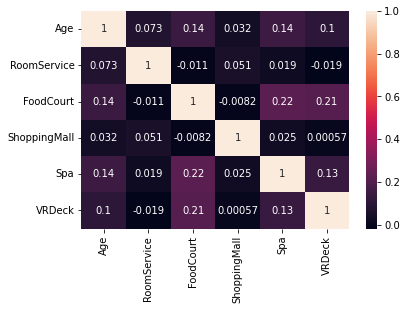

In [12]:
corr = train_df.loc[:, numerical_columns].corr()
sns.heatmap(corr, annot = True)
plt.show()

In [13]:
#sns.pairplot(train_df.loc[:, numerical_columns])
#plt.show()

Take away: 
* No clear correlation between numerical data.
* Predicting missing values of a certain column using the other columns does not seem like a good idea here.

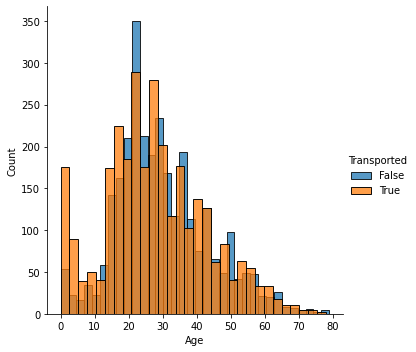

In [14]:
sns.FacetGrid(train_df, hue = "Transported", height=5).map(sns.histplot, "Age").add_legend()
plt.show()

Take away:
* Kids have good chances of survival.
* People in their twenties have bad chances of survival.

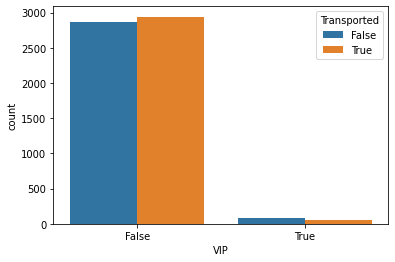

In [15]:
ax = sns.countplot(x="VIP", hue="Transported", data=train_df)
plt.show()

Take away:
* being VIP does not increase the chances of survival.
* When filling the missing values we can use the (mode), because being VIP does not have a huge influence on the chances of sruvival.

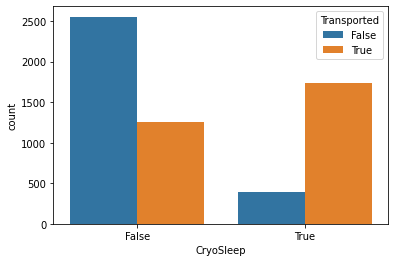

In [16]:
ax = sns.countplot(x="CryoSleep", hue="Transported", data=train_df)
plt.show()

Take away: 
* CryoSleepers have more chances of survival.
* When filling missing data, we will create a new category U (Unknown).

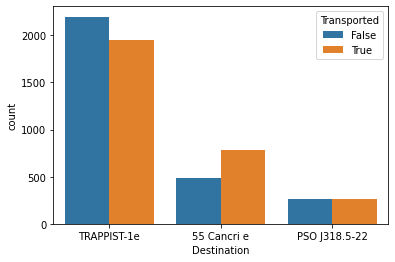

In [17]:
ax = sns.countplot(x="Destination", hue="Transported", data=train_df)
plt.show()

Take away:
* People heading to 55 Cancri e have good chances of survival.
* People heading to TRAPPIST-1e have bad chances of survival.
* Heading to PSO J318.5-22 does not affect the chances of survival.
* When filling missing data, we will either use PSO J318.5-22 because it does not affect the chances of survival, or use a new category U (Unknown).

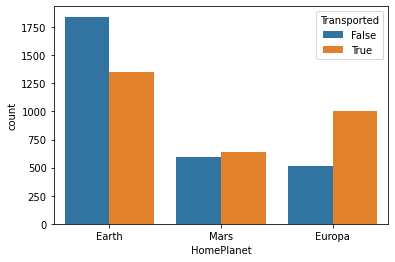

In [18]:
ax = sns.countplot(x="HomePlanet", hue="Transported", data=train_df)
plt.show()

Take away: 
* Coming from Europa increases the chances of survival.
* Coming from Earth decreases the chances of survival.
* Coming from Mars does not affect the chances of survival.
* When filling missing data, we will either use Mars because it does not affect the chances of survival, or use a new category U (Unknown).

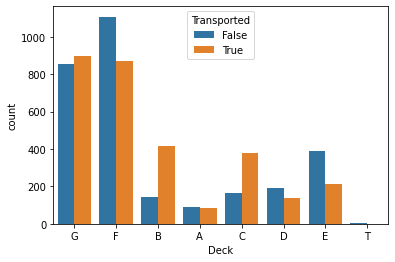

In [19]:
ax = sns.countplot(x="Deck", hue="Transported", data=train_df)
plt.show()

Take away:
* Very few people from deck T
* People from decks D, F, E have bad chances of survival.
* People from decks G, C, B have good chances of survival.
* Being from deck A does not affect the chances of survival significantly.
* When filling missing data, we will either use category A because it does not affect the chances of survival that much, or use a new category U (Unknown).

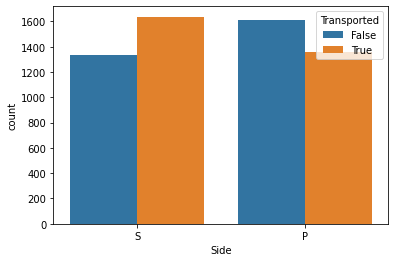

In [20]:
ax = sns.countplot(x="Side", hue="Transported", data=train_df)
plt.show()

Take away: 
* People on Port have bad chances of survival.
* People on Starboard have good chances of survival.
* When filling missing data, we will create a new category U (Unknown).

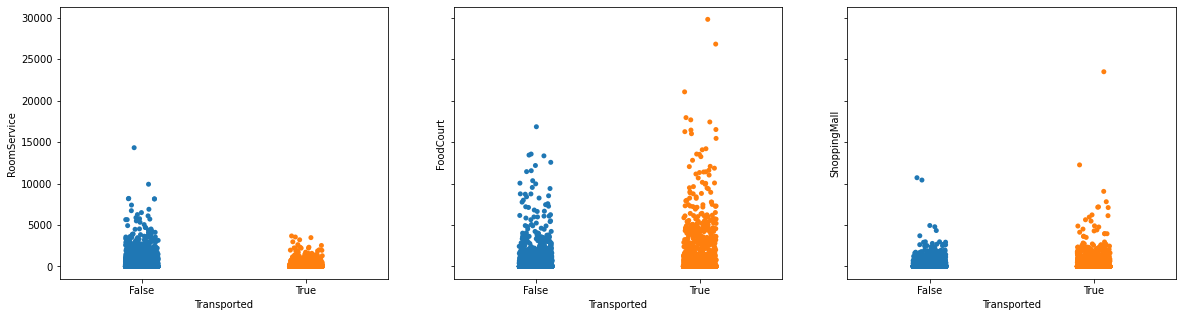

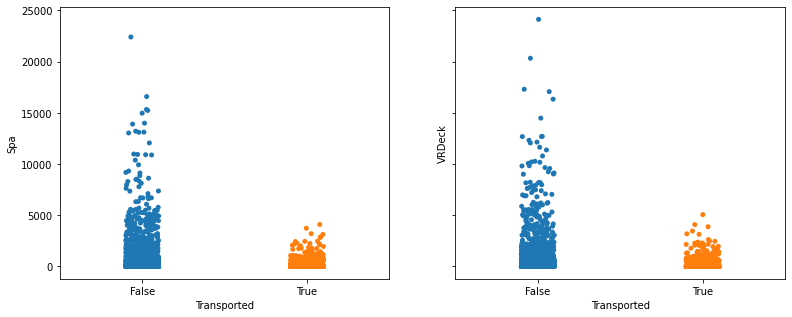

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.stripplot(x="Transported", y="RoomService", data=train_df, ax = axes[0])
sns.stripplot(x="Transported", y="FoodCourt", data=train_df, ax = axes[1])
sns.stripplot(x="Transported", y="ShoppingMall", data=train_df, ax = axes[2])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
sns.stripplot(x="Transported", y="Spa", data=train_df, ax = axes[0])
sns.stripplot(x="Transported", y="VRDeck", data=train_df, ax = axes[1])
plt.show()

Take away:
* Using the graphs we can not judge wether spending habits did affect survival chances or not.

#### Missing values.

In [22]:
isna = train_df.isna()

# total rows with missing values
total_rows_nan = 0
for row_idx in range(len(isna)):
    row = isna.loc[row_idx, :].values
    row_isna = row.any()
    if row_isna: total_rows_nan += 1

rows_percent = total_rows_nan / len(train_df)
print(f"Percentage of rows with missing data : {rows_percent * 100:.2f}%.")

# total missing values per column
nan_dict = {}
for column_name in isna.columns:
    column = isna.loc[:, column_name].values
    num_isna = np.sum(np.array(column, dtype = bool))
    nan_dict[column_name] = num_isna / len(train_df)

print(f"Percentage of missing data per column :")
for key, value in nan_dict.items():
    print(f"{key} : {value*100:.2f}%.")

Percentage of rows with missing data : 21.99%.
Percentage of missing data per column :
Deck : 2.37%.
Side : 2.37%.
HomePlanet : 2.35%.
CryoSleep : 2.42%.
Destination : 2.19%.
Age : 2.15%.
VIP : 2.38%.
RoomService : 2.19%.
FoodCourt : 2.02%.
ShoppingMall : 2.43%.
Spa : 1.87%.
VRDeck : 2.05%.
Transported : 0.00%.


Almost 20% of the dataset is missing, Normally we should check for patterns in the missing data but since the context of the competition speficies that the data was retreived from the ship's damaged computer system then we can consider that there are no patterns in missing data.

In [23]:
# I will fill a dictionnary with the means and modes 
# of the corresponding columns we will need to change.
# so here I initialize the two dicts.
means = {}
modes = {}

In [24]:
mean_age = train_df["Age"].mean().round(1)
print(f"The mean age is : {mean_age}.")

# Fill missing age.
train_df["Age"].fillna(mean_age, inplace = True)
print(f"Filled missing age with : {mean_age}")

means["Age"] = mean_age

The mean age is : 28.8.
Filled missing age with : 28.8


In [25]:
mode_columns = [
    "VIP", "Side", "Deck", "CryoSleep", 
    "HomePlanet", "Destination", 
    "RoomService", "FoodCourt", 
    "ShoppingMall", "Spa", "VRDeck"]

for c in mode_columns:
    category = train_df[c].mode()[0]
    train_df[c].fillna(category, inplace = True)
    modes[c] = category
    print(f"Filled missing {c} with : {category}.\n")

Filled missing VIP with : False.

Filled missing Side with : S.

Filled missing Deck with : F.

Filled missing CryoSleep with : False.

Filled missing HomePlanet with : Earth.

Filled missing Destination with : TRAPPIST-1e.

Filled missing RoomService with : 0.0.

Filled missing FoodCourt with : 0.0.

Filled missing ShoppingMall with : 0.0.

Filled missing Spa with : 0.0.

Filled missing VRDeck with : 0.0.



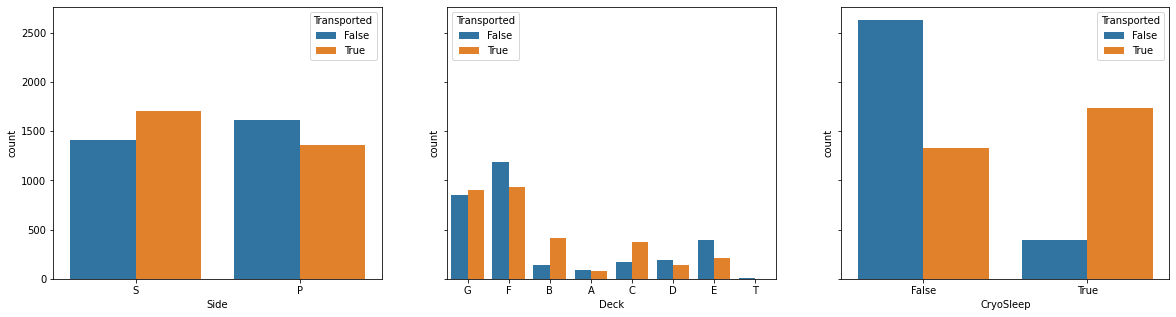

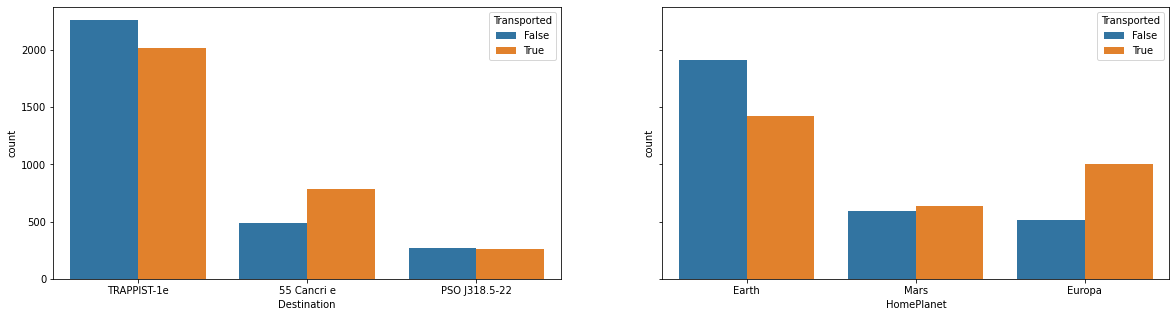

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.countplot(x="Side", hue="Transported", data=train_df, ax = axes[0])
sns.countplot(x="Deck", hue="Transported", data=train_df, ax = axes[1])
sns.countplot(x="CryoSleep", hue="Transported", data=train_df, ax = axes[2])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.countplot(x="Destination", hue="Transported", data=train_df, ax = axes[0])
sns.countplot(x="HomePlanet", hue="Transported", data=train_df, ax = axes[1])
plt.show()

In [27]:
isna = train_df.isna()

# total rows with missing values
total_rows_nan = 0
for row_idx in range(len(isna)):
    row = isna.loc[row_idx, :].values
    row_isna = row.any()
    if row_isna: total_rows_nan += 1

rows_percent = total_rows_nan / len(train_df)
print(f"Percentage of rows with missing data : {rows_percent * 100:.2f}%.")

# total missing values per column
nan_dict = {}
for column_name in isna.columns:
    column = isna.loc[:, column_name].values
    num_isna = np.sum(np.array(column, dtype = bool))
    nan_dict[column_name] = num_isna / len(train_df)

print(f"Percentage of missing data per column :")
for key, value in nan_dict.items():
    print(f"{key} : {value*100:.2f}%.")

Percentage of rows with missing data : 0.00%.
Percentage of missing data per column :
Deck : 0.00%.
Side : 0.00%.
HomePlanet : 0.00%.
CryoSleep : 0.00%.
Destination : 0.00%.
Age : 0.00%.
VIP : 0.00%.
RoomService : 0.00%.
FoodCourt : 0.00%.
ShoppingMall : 0.00%.
Spa : 0.00%.
VRDeck : 0.00%.
Transported : 0.00%.


### Data processing pipeline

Now that we are familiar with the dataset and we know the preprocessing we want to apply, let's implement it within a function to reuse it whenever we want.

In [28]:
from sklearn.preprocessing import StandardScaler

def preprocess(df, means, modes, binary_columns, categorical_columns, numerical_columns):
    df = split_cabin(df)
    df = df.drop(["PassengerId", "Name"], axis = 1)

    for c in means.keys():
        df[c].fillna(means[c], inplace = True)
    
    for c in modes.keys():
        df[c].fillna(modes[c], inplace = True)

    b_df = df.loc[:, binary_columns]
    b_df[b_df.columns] = b_df.values.astype(int)

    c_df = df.loc[:, categorical_columns]
    c_df = pd.get_dummies(c_df.loc[:, categorical_columns], dummy_na=True, prefix=categorical_columns)

    scaler = StandardScaler()
    n_df = df.loc[:, numerical_columns]
    n_df[n_df.columns] = scaler.fit_transform(n_df.values)
    return pd.concat([b_df, c_df, n_df], axis = 1)    

In [29]:
train_df, test_df = stratified_split(df = data, target = "Transported", test_size = 0.3)
print(f"TRAIN SIZE      : {len(train_df)}")
print(f"TESTT SIZE      : {len(test_df)}")

TRAIN SIZE      : 6085
TESTT SIZE      : 2608


While executing the rest of the cells, I faced an error because the test set does not include an example of an individual from Deck = T.

I Will add one from the training set.

Note : Adding one individual would not affect the results, it will only bypass the cells error.

In [30]:
individuals_idx = -1
for i in range(len(train_df)):
        cab = train_df.loc[i, "Cabin"]
        if isinstance(cab, str):
            deck, _, _ = cab.split('/')
            if deck == "T": 
                individuals_idx = i
                break

individual = pd.DataFrame({c: [train_df[c].iloc[individuals_idx]] for c in train_df.columns})
test_df = pd.concat((test_df, individual), axis = 0, ignore_index = True)

test_df.tail(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2608,1071_01,NaN,False,T/0/P,TRAPPIST-1e,35.0,False,415.0,1328.0,0.0,14.0,60.0,Alraida Dingauge,False


In [31]:
X_train = train_df.loc[:, train_df.columns != target]
y_train = train_df.loc[:, target]

X_test = test_df.loc[:, test_df.columns != target]
y_test = test_df.loc[:, target]

In [32]:
binary_columns = ["VIP", "CryoSleep"]
categorical_columns = [
    "HomePlanet", "Deck", 
    "Destination", "Side"]
numerical_columns = [
    "Age", "RoomService", "FoodCourt", 
    "ShoppingMall", "Spa", "VRDeck"]
mode_columns = [
    "VIP", "Side", "Deck", "CryoSleep",
    "HomePlanet", "Destination", 
    "RoomService", "FoodCourt", 
    "ShoppingMall", "Spa", "VRDeck"]

X_train = preprocess(
    X_train, means, modes, binary_columns, 
    categorical_columns, numerical_columns)

X_test = preprocess(
    X_test, means, modes, binary_columns, 
    categorical_columns, numerical_columns)

# Modeling

### Decision Trees

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = dt_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(dt_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = dt_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 72.80%.
test score : 71.41%.


In [34]:
import itertools

parameters = {
    "criterion" : ["gini", "entropy", "log_loss"], 
    "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    "max_features" : ["sqrt", "log2"],
    "ccp_alpha" : [0, 1, 2, 3]
    }

combinations = list(itertools.product(*parameters.values()))
best_score = 0
for param_combination in combinations:
    p_criterion, p_max_depth, p_max_features, p_ccp_alpha = param_combination
    dt_clf = DecisionTreeClassifier(
        criterion = p_criterion,
        max_depth = p_max_depth,
        max_features = p_max_features,
        ccp_alpha = p_ccp_alpha,
        random_state = 0)

    score = np.mean(cross_val_score(dt_clf, X_train, y_train))
    if score > best_score:
        best_score = score
        best_dt_clt = dt_clf
        best_params = param_combination

print(f"best parameters : {best_params}.")
print(f"best cross validation score : {best_score*100:.2f}%.")

best_dt_clt.fit(X_train, y_train)
score = best_dt_clt.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

best parameters : ('entropy', 10, 'sqrt', 0).
best cross validation score : 76.70%.
test score : 76.08%.


### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = rf_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 78.54%.
test score : 77.54%.


In [36]:
parameters = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    "max_features" : ["sqrt", "log2"],
    "ccp_alpha" : [0, 1, 2]
    }

combinations = list(itertools.product(*parameters.values()))
best_score = 0
for param_combination in combinations:
    p_criterion, p_max_depth, p_max_features, p_ccp_alpha = param_combination
    rf_clf = RandomForestClassifier(
        criterion = p_criterion,
        max_depth = p_max_depth,
        max_features = p_max_features,
        ccp_alpha = p_ccp_alpha,
        random_state = 0,
        n_jobs = -1)

    score = np.mean(cross_val_score(rf_clf, X_train, y_train))
    if score > best_score:
        print(score)
        best_score = score
        best_rf_clf = rf_clf
        best_params = param_combination

n_estimators = [5, 10, 50, 100, 150]
p_criterion, p_max_depth, p_max_features, p_ccp_alpha = best_params
for n_est in n_estimators:
    rf_clf = RandomForestClassifier(
        n_estimators = n_est,
        criterion = p_criterion,
        max_depth = p_max_depth,
        max_features = p_max_features,
        ccp_alpha = p_ccp_alpha,
        random_state = 0,
        n_jobs = -1)

    score = np.mean(cross_val_score(rf_clf, X_train, y_train))
    if score > best_score:
        print(score)
        best_score = score
        best_rf_clf = rf_clf
        best_params = (n_est,) + param_combination

print(f"best parameters : {best_params}.")
print(f"best cross validation score : {best_score*100:.2f}%.")

best_rf_clf.fit(X_train, y_train)
score = best_rf_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

0.7410024650780608
0.743467543138866
0.7569433032046013
0.7732128184059163
0.7870172555464257
0.7903040262941661
0.790468364831553
0.7981922760887429
0.8039441248972883
best parameters : ('gini', 9, 'sqrt', 0).
best cross validation score : 80.39%.
test score : 79.23%.


### Decision Tree Graph

In [37]:
dt_clf = DecisionTreeClassifier(max_leaf_nodes = 20)
dt_clf = dt_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(dt_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = dt_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 78.37%.
test score : 77.65%.


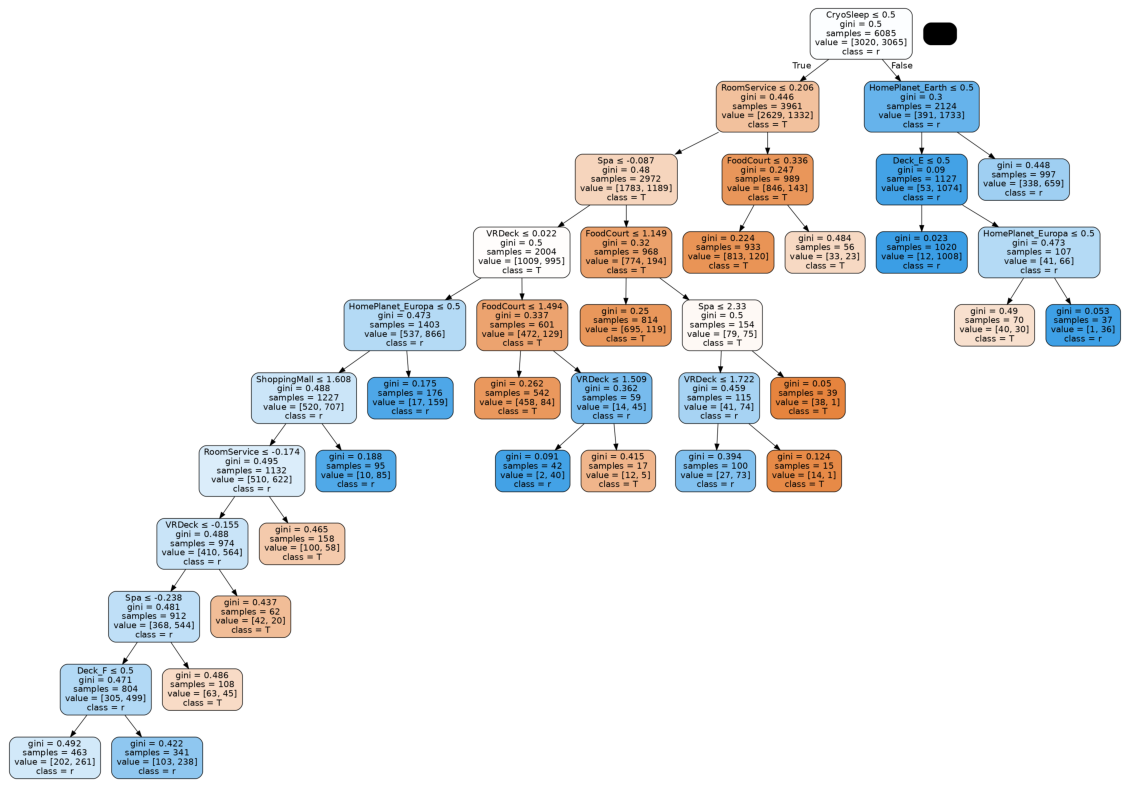

In [38]:
import pydotplus
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt_clf, out_file=None, 
                     feature_names=X_train.columns,  
                     class_names=target,  
                     filled=True, rounded=True,  
                     special_characters=True)  

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"30,30!"')
pydot_graph.write_png("decision_tree_max_node_leaf_20.png")

im = plt.imread("decision_tree_max_node_leaf_20.png")
plt.figure(figsize = (20,20))
plt.imshow(im)
plt.axis("off")
plt.show()

We should never use decision trees to do variable selection, but visualizing the decision tree might help us get an idea about the feature engineerings we could apply.

Here I noticed that half of the tree is decided using spending habits of individuals. So I am going to create a new column containing the sum of all the spendings. Let's try it out.

In [39]:
binary_columns = ["VIP", "CryoSleep"]
categorical_columns = ["HomePlanet", "Deck", "Destination", "Side"]
numerical_columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
spending_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

X_train = train_df.loc[:, train_df.columns != target]
y_train = train_df.loc[:, target]

X_test = test_df.loc[:, test_df.columns != target]
y_test = test_df.loc[:, target]


X_train = preprocess(
    X_train, means, modes, binary_columns, 
    categorical_columns, numerical_columns)

X_test = preprocess(
    X_test, means, modes, binary_columns, 
    categorical_columns, numerical_columns)

dataframes = [X_train, X_test]
for df in dataframes:
    df["Total_Spending"] = df.loc[:, spending_columns].sum(axis = 1)
    #df.drop(spending_columns, axis = 1)

In [40]:
best_dt_clt = best_dt_clt.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(best_dt_clt, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = best_dt_clt.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 75.99%.
test score : 74.78%.


In [41]:
best_rf_clf = best_rf_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(best_rf_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = best_rf_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 80.05%.
test score : 79.76%.


### SVM

In [43]:
from sklearn.svm import SVC

svc_clf = SVC(random_state = 0)
svc_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(svc_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = svc_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

cross validation score : 80.27%.
test score : 78.45%.


In [115]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "C" : [0.0001, 1, 10, 20],
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    "gamma" : ["scale", "auto"],
    "decision_function_shape" : ["ovo", "ovr"]
    }

svc_clf = SVC(random_state = 0)
grid_tuner = GridSearchCV(svc_clf, parameters)
grid_tuner.fit(X_train, y_train)


print("Best parameters : ")
print(grid_tuner.best_params_)

print("\nBest cross validation score : ")
print(f"{grid_tuner.best_score_}%")

best_svc_clf = grid_tuner.best_estimator_
score = best_svc_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

Best parameters : 
{'C': 20, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'poly'}

Best cross validation score : 
0.8058407079646018%
test score : 79.30%.


### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(ada_clf, X_train, y_train))
print(f"cross validation score : {cv_score * 100:.2f}%.")

score = ada_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")


cross validation score : 79.15%.
test score : 77.33%.


### XGBoost

In [35]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

score = xgb_clf.score(X_test, y_test)
print(f"test score : {score * 100:.2f}%.")

test score : 78.45%.


### Gradient Boosting Classifier

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()


cv_score = np.mean(cross_val_score(clf, X_train, y_train))
print(f"cross validation score : {cv_score*100:.2f}%")

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"test score : {score*100:.2f}%")

cross validation score : 80.39%
test score : 78.71%


### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.score(X_test, y_test)

0.7766097240473062

### MLP

In [56]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (100, 10, 1),random_state=1, max_iter=100_000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7805519053876478

# Submitting

In [52]:
from sklearn.preprocessing import StandardScaler

def preprocess(df, means, modes, binary_columns, categorical_columns, numerical_columns):
    df = split_cabin(df)
    df = df.drop(["PassengerId", "Name"], axis = 1)

    for c in means.keys():
        df[c].fillna(means[c], inplace = True)
    
    for c in modes.keys():
        df[c].fillna(modes[c], inplace = True)

    b_df = df.loc[:, binary_columns]
    b_df[b_df.columns] = b_df.values.astype(int)

    c_df = df.loc[:, categorical_columns]
    c_df = pd.get_dummies(c_df.loc[:, categorical_columns], dummy_na=True, prefix=categorical_columns)

    scaler = StandardScaler()
    n_df = df.loc[:, numerical_columns]
    n_df[n_df.columns] = scaler.fit_transform(n_df.values)
    return pd.concat([b_df, c_df, n_df], axis = 1)    

In [70]:
X_train = train_df.loc[:, train_df.columns != target]

INPUT_PATH : str = "./spaceship-titanic/test.csv"
X_input = pd.read_csv(INPUT_PATH)
PassengerId = X_input.PassengerId

# Before applying preprocessing, we will concatenate
# the two dataset in order to have same number of 
# categorical dummies but we will of course separate both
# datasets on output.

X_all = pd.concat([X_input, X_train], axis = 0).reset_index()
X_all = preprocess(
    X_all, means, modes, binary_columns,
    categorical_columns, numerical_columns
    )

X_input = X_all.loc[:len(X_input)-1, :]
X_input["Total_Spending"] = X_input.loc[:, spending_columns].sum(axis = 1)
y_pred = best_rf_clf.predict(X_input)

/tmp/ipykernel_122921/976253719.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_input["Total_Spending"] = X_input.loc[:, spending_columns].sum(axis = 1)


In [74]:
out_df = pd.DataFrame(PassengerId)
out_df[target] = y_pred
out_df.to_csv("out.txt", index = False)